データ読み込みとグラフ出力による確認

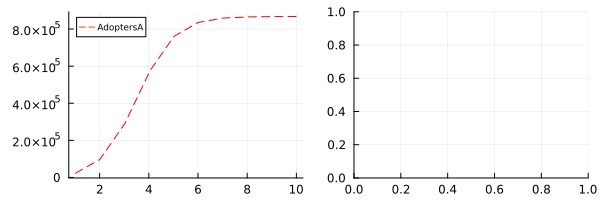

c:\Users\kmako\Dropbox\JuliaDocs\NortonBassModel

In [1]:
using Plots
using CSV
using DataFrames 
println(pwd())
# Function to load data
function load_data(filepath)
    data = CSV.read(filepath, DataFrame)
    return data[:,1], data[:,2]
end

# Define labels and filepaths for the plots
file_labels = [("AdpotersAdata.csv", "AdoptersA", "U1[t]")
              ]

# Define indices for Y variables
#Y_indices = [1]

# Create combined plots
p_combined = plot(layout=(1,2), size=(600,200))

for i in 1:length(file_labels)
    filepath, data_label, sol_label = file_labels[i]
    # Load data
    t, y = load_data(filepath)
    # Plot data from external files
    plot!(p_combined[i], t, y, label=data_label, legendfontsize=6, linestyle=:dash, linecolor=:red)
    # Plot calculated results
   # plot!(p_combined[i], sol.t, sol[Y_indices[i],:], label=sol_label, legendfontsize=6, linecolor=:blue)
end

# Display the combined plot
display(p_combined)

パラメータは4変数を最適化する．Limited-memory Broyden–Fletcher–Goldfarb–Shanno (L-BFGS) を最適化手法として用いる．目的関数としてハバーロス（Huber Loss）を利用する。ハバーロスは、二乗誤差と絶対誤差を組み合わせた損失関数であり、異常値の影響を受けにくい特性を持つ．パラメータ最適化のための最小値と最大値を設定する．Huber loss関数のデルタパラメータを 1.0 に調整した。これはより大きな異常値に対するロバスト性を提供する．
f_tol 値を 1e-10 に設定した。この値を小さくすることで、最適化アルゴリズムはより高精度を指向する．

In [3]:
using Optim
using DifferentialEquations
using CSV
using DataFrames 
# Parameters
TIMESTEP = 0.015625
TMAX = 10
TotalPopulationN = 1e+06

# System of ODEs
function system!(du, u, p, t)
    AdoptersA, PotentialAdoptersP = u
AdoptionFractioni, AdvertisingEffectivenessa, ContactRatec, AverageProductLifel = p
    AdoptionfromAdvertising = AdvertisingEffectivenessa * PotentialAdoptersP
    AdoptionfromWordofMouth = ContactRatec * AdoptionFractioni * PotentialAdoptersP * AdoptersA / TotalPopulationN
    AdoptionRateAR = AdoptionfromAdvertising + AdoptionfromWordofMouth
    DiscardRate = AdoptersA / AverageProductLifel

    du[1] = AdoptionRateAR - DiscardRate
    du[2] = -AdoptionRateAR + DiscardRate
end

u0 = [0, TotalPopulationN]
tspan = (0.0, TMAX)
p_initial = [0.01, 0.01, 10, 1]  # Adjust initial values
prob = (p) -> ODEProblem(system!, u0, tspan, p)

function load_data(filename)
    data = CSV.read(filename, DataFrame)
    t_data = data[:,1] 
    y_data = data[:,2]
    return t_data, y_data
end

# Huber loss function
function huber_loss(y_true, y_pred, δ=1.0)  # Adjust delta parameter
    return sum(abs2(x) <= δ^2 ? 0.5*x^2 : δ*(abs(x) - 0.5*δ^2) for x in (y_true - y_pred))
end

function objective(p)
    sol = solve(prob(p), Tsit5(), reltol=1e-8, abstol=1e-8)
    t_data, y_data = load_data("AdpotersAdata.csv")
    sol_interpolated = [sol(t)[1] for t in t_data]
    return huber_loss(y_data, sol_interpolated)  # Use Huber loss
end

# We use the L-BFGS algorithm and finite difference gradients
lower = [0.0001, 0.0001, 0.1, 0.01]  # Lower bounds for parameters
upper = [1, 1, 1000, 100]  # Upper bounds for parameters
inner_optimizer = LBFGS()  # Can also try different optimizer
res = optimize(objective, lower, upper, p_initial, Fminbox(inner_optimizer), Optim.Options(f_tol = 1e-10), autodiff = :finite)

p_optimal = Optim.minimizer(res)
println("Optimal value for AdoptionFractioni: ", p_optimal[1])
println("Optimal value for AdvertisingEffectivenessa: ", p_optimal[2])
println("Optimal value for ContactRatec: ", p_optimal[3])
println("Optimal value for AverageProductLifel: ", p_optimal[4])



Optimal value for AdoptionFractioni: 0.03100339482644864
Optimal value for AdvertisingEffectivenessa: 0.010998708133417903
Optimal value for ContactRatec: 48.38364543056766
Optimal value for AverageProductLifel: 4.99970332895514


最適値を用いた時間積分結果の出力

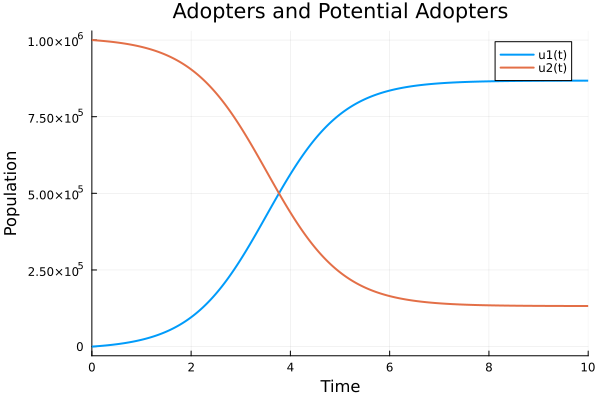

In [4]:
using Plots

# Solve the ODE problem with the optimal parameter value
sol = solve(prob(p_optimal), Tsit5(), reltol=1e-8, abstol=1e-8)

# Plot results
plot(sol, xlabel="Time", ylabel="Population", title="Adopters and Potential Adopters", lw=2)

キャリブレーション結果のグラフ出力（１）

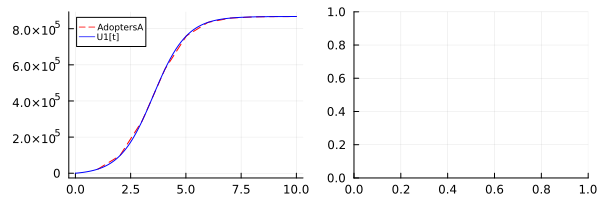

In [5]:
using Plots
using CSV
using DataFrames 

# Function to load data
function load_data(filepath)
    data = CSV.read(filepath, DataFrame)
    return data[:,1], data[:,2]
end

# Define labels and filepaths for the plots
file_labels = [("AdpotersAdata.csv", "AdoptersA", "U1[t]")
              ]

# Define indices for Y variables
Y_indices = [1]

# Create combined plots
p_combined = plot(layout=(1,2), size=(600,200))

for i in 1:length(file_labels)
    filepath, data_label, sol_label = file_labels[i]
    # Load data
    t, y = load_data(filepath)
    # Plot data from external files
    plot!(p_combined[i], t, y, label=data_label, legendfontsize=6, linestyle=:dash, linecolor=:red)
    # Plot calculated results
   plot!(p_combined[i], sol.t, sol[Y_indices[i],:], label=sol_label, legendfontsize=6, linecolor=:blue)
end

# Display the combined plot
display(p_combined)

キャリブレーション結果のグラフ出力（2）

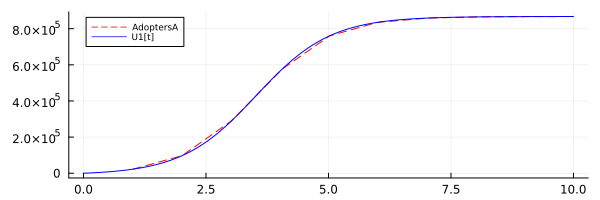

"c:\\Users\\kmako\\Dropbox\\JuliaDocs\\NortonBassModel\\NB021_plot.pdf"

In [6]:
using Plots
using CSV
using DataFrames 

# Function to load data
function load_data(filepath)
    data = CSV.read(filepath, DataFrame)
    return data[:,1], data[:,2]
end

# Define labels and filepaths for the plots
file_labels = [("AdpotersAdata.csv", "AdoptersA", "U1[t]")
              ]

# Define indices for Y variables
Y_indices = [1]

# Create a single plot
p = plot(size=(600,200))

for i in 1:length(file_labels)
    filepath, data_label, sol_label = file_labels[i]
    # Load data
    t, y = load_data(filepath)
    # Plot data from external files
    plot!(p, t, y, label=data_label, legendfontsize=6, linestyle=:dash, linecolor=:red)
    # Plot calculated results
    plot!(p, sol.t, sol[Y_indices[i],:], label=sol_label, legendfontsize=6, linecolor=:blue)
end

# Display the plot
display(p)
# Save the plot to a file
savefig(p, "NB021_plot.png")
savefig(p, "NB021_plot.svg")
savefig(p, "NB021_plot.pdf")

データフレーム用パッケージの追加

各データセットに対して決定係数(R^2)、Theilの不等式統計（Um, Us, Uc）、平均絶対誤差（MAE）、平均二乗誤差（MSE）、そして平均絶対パーセント誤差（MAPE）を計算し、結果をDataFrameに保存する。その後、DataFrameの内容を出力する。ここで、各行は特定のデータセットに対応し、各列は誤差指標に対応する。

各変数の時系列変化値を表形式で表示する

In [6]:
using Statistics
using DataFrames
using Interpolations

# Function to load data
function load_data(filepath)
    data = CSV.read(filepath, DataFrame)
    return data[:,1], data[:,2]
end

# Define labels and filepaths for the plots
file_labels = [("AdpotersAdata.csv", "AdoptersA", "U1[t]")]

# Define indices for Y variables
Y_indices = [1]

# Define DataFrame for storing error metrics
error_metrics_df = DataFrame(
    DataLabel = String[], 
    NumberOfDataPoints = Int64[], # Add field for number of data points
    R2 = Float64[],  # R^2 (Coefficient of determination)
    Um = Float64[],  # Theil's inequality statistics
    Us = Float64[],
    Uc = Float64[],
    MAE = Float64[], 
    MSE = Float64[], 
    MAPE = Float64[]
)

for i in 1:length(file_labels)
    filepath, data_label, sol_label = file_labels[i]
    # Load data
    t, y = load_data(filepath)
    # Record the number of data points
    num_data_points = length(t)
    # Get the range of time values for which data exists
    t_min, t_max = minimum(t), maximum(t)
    # Filter sol's time points to the range of time values for which data exists
    sol_indices = (sol.t .>= t_min) .& (sol.t .<= t_max)
    sol_t, sol_y = sol.t[sol_indices], sol[Y_indices[i],sol_indices]
    # Interpolate the numerical solution to match the time steps of the loaded data
    interp_func = LinearInterpolation(sol_t, sol_y, extrapolation_bc=Line())
    sol_y_interp = interp_func.(t)
    # Compute the errors
    errors = abs.(y - sol_y_interp)
    # Compute MAE, MSE, and MAPE
    mae = mean(errors)
    mse = mean(errors.^2)
    mape = mean(errors ./ abs.(y)) * 100
    # Compute R-squared (coefficient of determination)
    ss_total = sum((y .- mean(y)).^2)
    ss_res = sum((y .- sol_y_interp).^2)
    r2 = 1 - ss_res/ss_total
    # Compute Theil's inequality statistics
    y_mean = mean(y)
    sol_y_interp_mean = mean(sol_y_interp)
    um = sqrt(sum((y - sol_y_interp).^2)) / (sqrt(sum((y.^2)) + sqrt(sum((sol_y_interp).^2))))
    us = sqrt(sum(((y .- y_mean) .- (sol_y_interp .- sol_y_interp_mean)).^2)) / sqrt(sum((y .- y_mean).^2))
    uc = sqrt(sum(((y .- y_mean) .+ (sol_y_interp .- sol_y_interp_mean)).^2)) / sqrt(sum((y .+ sol_y_interp).^2))
    
    # Check if um + us + uc is close to 1, if not adjust the values
    total = um + us + uc
    if abs(total - 1) > 1e-6
        um /= total
        us /= total
        uc /= total
    end
    
    # Append the computed error metrics to the DataFrame
    push!(error_metrics_df, (data_label, num_data_points, r2, um, us, uc, mae, mse, mape))
end

# Print the DataFrame containing R^2, Theil's inequality statistics, MAE, MSE, and MAPE values
println(error_metrics_df)
#
CSV.write("error_metrics21.csv", error_metrics_df)

1×9 DataFrame
 Row │ DataLabel  NumberOfDataPoints  R2       Um         Us           Uc        MAE      MSE      MAPE      
     │ String     Int64               Float64  Float64    Float64      Float64   Float64  Float64  Float64   
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ AdoptersA                  10      1.0  0.0003508  0.000735468  0.998914  64.8192  12878.3  0.0683281


"error_metrics21.csv"